<a href="https://colab.research.google.com/github/vlordier/colabs/blob/main/QA_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Please, Go to Ahmed Part

## Don't Run this

In [ ]:

#!pip install transformers
!pip install -q rpunct
!pip install -q language_tool_python
!pip install -q clean-text[gpl]
!pip install -q textblob
!pip install -q nlpaug
!pip install -q praw
#!pip uninstall pandas
#!pip install pandas==1.1.5

     |████████████████████████████████| 213 kB 5.4 MB/s 
     |████████████████████████████████| 9.9 MB 50.3 MB/s 
     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 981 kB 39.7 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 6.8 MB 33.3 MB/s 
     |████████████████████████████████| 311 kB 49.2 MB/s 
     |████████████████████████████████| 1.7 MB 45.4 MB/s 
     |████████████████████████████████| 124 kB 48.4 MB/s 
     |████████████████████████████████| 9.7 MB 33.5 MB/s 
     |████████████████████████████████| 1.2 MB 42.7 MB/s 
     |████████████████████████████████| 3.5 MB 43.6 MB/s 
     |████████████████████████████████| 895 kB 43.0 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 1.1 MB 38.8 MB/s 
     |████████████████████████████████| 243 kB 42.2 MB/s 
     |████████████

In [ ]:
import sys
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import json
import torch
import argparse 
import gc
from tqdm import tqdm
from pathlib import Path
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
# from comet_atomic2020_bart.utils import calculate_rouge, use_task_specific_params, calculate_bleu_score, trim_batch
from rpunct import RestorePuncts
import language_tool_python
import sys
import warnings
from spacy.lang.en import English
from cleantext import clean
from textblob import TextBlob
import re
import nltk
nltk.download('brown')
import nltk
nltk.download('punkt')
import nltk
from textblob import TextBlob

import pandas as pd
nltk.download('averaged_perceptron_tagger')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### **Preprocessing Block**

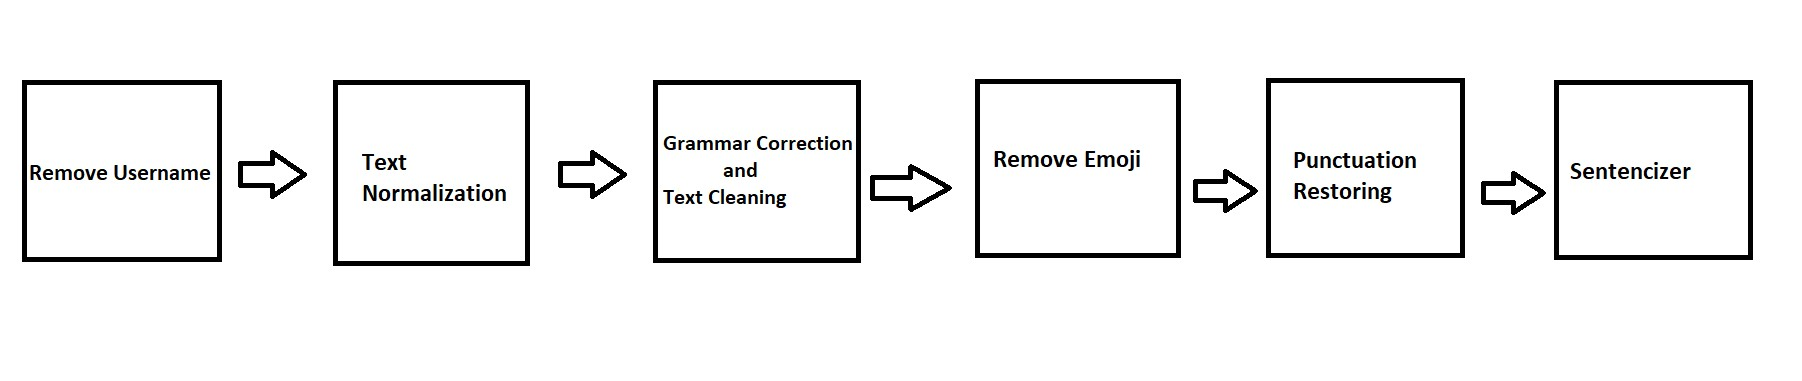

In [ ]:
def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)


def textNormalization(text):
    processed_text=clean(text,
                        fix_unicode=True,               # fix various unicode errors
                        to_ascii=True,                  # transliterate to closest ASCII representation
                        lower=False,                     # lowercase text
                        no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
                        no_urls=  True,                  # replace all URLs with a special token
                        no_emails=True,                # replace all email addresses with a special token
                        no_phone_numbers=True,         # replace all phone numbers with a special token
                        no_numbers=False,               # replace all numbers with a special token
                        no_digits=False,                # replace all digits with a special token
                        no_currency_symbols=True,      # replace all currency symbols with a special token
                        no_punct=False,                 # remove punctuations
                        replace_with_punct="",          # instead of removing punctuations you may replace them
                        replace_with_url="",
                        replace_with_email="",
                        replace_with_phone_number="",
                        replace_with_number="",
                        replace_with_digit="0",
                        replace_with_currency_symbol=" dollars",
                        lang="en")

    return processed_text


def remove_emoji(processed_text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    processed_text=emoji_pattern.sub(r'', processed_text)
    return processed_text
def remStopWordsOur(lineIn):
    stopWords= {'i','a','and','about','an','are','as','at','be','by','com','for','from','how','in','is','it','not','of','on','or','that','the','this','to','was','what','when','where','who','will','with','the','www','your','is','am','some','you','your','I','A','And','About','An','Are','As','At','Be','By','Com','For','From','How','In','Is','It','Not','Of','On','Or','That','The','This','To','Was','What','When','Where','Who','Will','With','The','Www','Your','Is','Am','Some','You','Your','Was'}
    rmdStopWordsLn = ' '.join(w for w in lineIn.split() if w.lower() not in stopWords)
    return rmdStopWordsLn


def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

# if is_lower:
#    text=text.lower()
  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  #text = re.sub(r'[^\w\s]',' ',text)
  #text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text


def rem_username(text):
  text = ' '.join(re.sub("([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)"," ", text).split())
  return text


#Main preprocessing block
def preprocessing_block(text):
# The default language is 'english'
  #1. Remove username
  processed_text=rem_username(text)
  #2. Text Normalization and remove URLs
  processed_text=textNormalization(processed_text)
  #3. Grametetical error correction and text cleaning
  tool = language_tool_python.LanguageTool('en')
  processed_text = tool.correct(processed_text)
  processed_text=clean_text(processed_text)
  #4 remove emoji in text
  processed_text=remove_emoji(str(processed_text))
  #5. punctuations restoring
  rpunct = RestorePuncts()
  processed_text=rpunct.punctuate(processed_text)
  #6. sentence spliting
  nlp = English()
  sbd = nlp.create_pipe('sentencizer')
  nlp.add_pipe(sbd)
  doc = nlp(str(processed_text))
  sents_list = []
  for sent in doc.sents:
     sents_list.append(sent.text)
  return sents_list


In [ ]:
text="hello world"
processed=preprocessing_block(text)

Unzipping /tmp/tmpkmrt90n9.zip to /root/.cache/language_tool_python.
Downloaded https://www.languagetool.org/download/LanguageTool-5.6.zip to /root/.cache/language_tool_python.


Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/530 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
processed

['Hello World.']

# Invoke reddit data (Ahmed Part)

## Run from Here

Asynchronous Praw

In [ ]:
!pip install -q asyncpraw
!pip install -q praw
!pip install -q nest-asyncio

     |████████████████████████████████| 183 kB 23.9 MB/s 
     |████████████████████████████████| 1.1 MB 60.3 MB/s 
     |████████████████████████████████| 271 kB 45.6 MB/s 
     |████████████████████████████████| 144 kB 53.1 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 176 kB 25.3 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import os
import csv
import time
import asyncpraw
import nest_asyncio
import asyncio
import pandas as pd
from io import StringIO
from contextlib import suppress
from asyncpraw.models import MoreComments
from typing import Text, List, Tuple, Dict, Union

Create the Dataset Directory

In [ ]:
MAIN = '/content/drive/MyDrive'
PROJECT = 'QA Generator'
DATASET_DIR = 'Dataset'
if not os.path.isdir(os.path.join(MAIN, PROJECT, DATASET_DIR)):
  os.mkdir(PROJECT)
  os.mkdir(os.path.join(PROJECT, DATASET_DIR))

Connect with the app

In [ ]:
reddit = asyncpraw.Reddit(client_id = 't78ZwNDc5W81d_A58e-qRQ',
                          client_secret='EG4JKb5w4DRouhwa1f08RekCG2Sjkg',
                          user_agent='testscript by /u/AI-Ahmed',
                          username='AI-Ahmed')

Scrape the Threads > Title, answers

In [ ]:
async def topic_fn(topic: Text, limit: int):
  ml_posts = await reddit.subreddit(topic)
  return ml_posts.hot(limit=limit) 


async def title_id_scrape(topic: asyncpraw.models.listing.generator.ListingGenerator) -> Dict[List[Text], List[Text]]:
  thread = {"title": [],
            "id": [],
            "body": [],
            'subreddit': []}
  async for post in topic:
    thread['title'].append(post.title)
    thread['id'].append(post.id)
    thread['body'].append(post.selftext)
    thread['subreddit'].append(post.subreddit.display_name)
  return thread

def title_token(titles: List[Text]) -> List[Text]:
  token = re.compile(r'(\[\w]\s)')
  return list(map(lambda sentence: re.sub(token, '', sentence), titles))


async def comments_fn(ids: List[Text], comment_len:int=5) -> List[Text]:
  comments_list = []
  for index, id in enumerate(ids):
    submission = await reddit.submission(id=id)
    comments = await submission.comments()

    for index in range(comment_len):
      try:
        comments_list.append(comments.list()[index].body)
      except IndexError:
        comments_list.append('No Answer Provided!')
  return comments_list


def add_comments_column(thread: Dict[Text, Text], 
                        comments_list: List[List],
                        comments_len: int) -> Dict[Text, Text]:
  for index in range(comments_len):
    thread[f'comment_{index+1}'] = [comments_list[index]]
  return thread

def reshape(lst: List[Text]):
    return list(map(lambda element:[element], lst))

async def main():
  columns = ["title", "body", 'subreddit',
             'comment_1', 'comment_2', 'comment_3',
             'comment_4', 'comment_5']
  output = StringIO()
  csv_writer = csv.writer(output)
  for topic in LIST_OF_TOPICS:
    posts = await topic_fn(topic, LIMITED_POSTS)
    thread = await title_id_scrape(posts)
    thread['title'] = title_token(thread['title'])
    comment_list = await comments_fn(thread['id'], 5)
    thread = add_comments_column(thread, comment_list, 5)
    thread.pop('id')

    csv_writer.writerows(zip(*thread.values()))

  #   # # Save the file
  #   # with open(os.path.join(MAIN, PROJECT, DATASET_DIR, 'posts.csv'), 'a', newline='') as csv_file:
  #   #   writer = csv.writer(csv_file)
  #   #   writer.writerows(zip(*thread.values()))
  output.seek(0) # we need to get back to the start of the StringIO
  df = pd.read_csv(output, names=columns)
  df.to_json(os.path.join(MAIN, PROJECT, DATASET_DIR, 'posts.json'), indent=4)

Select **Machine Learning Topic**

In [ ]:
LIST_OF_TOPICS = ['mentalhealth', 'self', 'changemyview', 'relationship_advice', 'anxiety', 'depression', 'selfimprovement']
LIMITED_POSTS = 1e5 #100,000 rows for each topic

In [ ]:
nest_asyncio.apply()
loop = asyncio.get_event_loop()
event = asyncio.run(main())

#stop the loop
try:
  event.cancel()
except AttributeError:
  print('No Event Open')
else:
  print(f'Event is Cancelled: {event.cancelled()}')
  print('=== Done Scraping ===')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: `Submission.comments` is now a property and no longer needs to be awaited. This will raise an error in a future version of Async PRAW.


No Event Open


Don't Run anything else!

---

## **Reddit Data Collector (Testing)** 

In [ ]:
!pip install -q reddit-data-collector

     |████████████████████████████████| 176 kB 4.2 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 


In [ ]:
import reddit_data_collector as rdc

In [ ]:
data_collector  = rdc.DataCollector(client_id = 't78ZwNDc5W81d_A58e-qRQ',
                                    client_secret='EG4JKb5w4DRouhwa1f08RekCG2Sjkg',
                                    user_agent='testscript by /u/AI-Ahmed',
                                    username='AI-Ahmed')

In [ ]:
posts, comments = data_collector.get_data(
                    subreddits='MachineLearning',
                    post_filter='hot',
                    post_limit=10
)

It appears that you are using PRAW in an asynchronous environment.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: htt

In [ ]:
posts_df = rdc.to_pandas(posts)
comments_df = rdc.to_pandas(comments)

In [ ]:
posts_df

,subreddit_name,post_created_utc,id,is_original_content,is_self,link_flair_text,locked,num_comments,over_18,score,spoiler,stickied,title,upvote_ratio,url
0,MachineLearning,1.643558e+09,sgc6cn,False,True,Discussion,False,96,False,14,False,True,[D] Simple Questions Thread,0.90,https://www.reddit.com/r/MachineLearning/comme...
1,MachineLearning,1.643576e+09,sgisxq,False,True,Discussion,False,7,False,25,False,True,[D] Machine Learning - WAYR (What Are You Read...,0.85,https://www.reddit.com/r/MachineLearning/comme...
2,MachineLearning,1.644406e+09,sobfvm,False,True,Project,False,5,False,91,False,False,[P] What we learned by accelerating by 5X Hugg...,0.96,https://www.reddit.com/r/MachineLearning/comme...
3,MachineLearning,1.644407e+09,sobosz,False,True,Research,False,7,False,35,False,False,[R] Towards understanding deep learning with t...,0.84,https://www.reddit.com/r/MachineLearning/comme...
4,MachineLearning,1.644414e+09,sodrv6,False,True,Research,False,0,False,13,False,False,[R] Free book on Causal ML (w/code)!,1.00,https://www.reddit.com/r/MachineLearning/comme...
5,MachineLearning,1.644334e+09,snmtzn,False,True,Research,False,76,False,458,False,False,[R] PhD thesis: On Neural Differential Equations!,0.98,https://www.reddit.com/r/MachineLearning/comme...
6,MachineLearning,1.644415e+09,soedzt,False,True,Discussion,False,5,False,2,False,False,[D] request | Network architecture visualizati...,1.00,https://www.reddit.com/r/MachineLearning/comme...
7,MachineLearning,1.644400e+09,so9s0a,False,True,Discussion,False,6,False,4,False,False,[D] Using Standard Scaler on Sparse PCA (SPCA)...,1.00,https://www.reddit.com/r/MachineLearning/comme...
8,MachineLearning,1.644422e+09,sogz9l,False,True,News,False,0,False,1,False,False,[N] **CFP:** Special Session on Low-Resource A...,1.00,https://www.reddit.com/r/MachineLearning/comme...
9,MachineLearning,1.644361e+09,snxka2,False,True,Project,False,2,False,22,False,False,[P] The Cedille paper is out! (largest French ...,0.90,https://www.reddit.com/r/MachineLearning/comme...


In [ ]:
comments_df.head(10)

,subreddit_name,id,post_id,parent_id,top_level_comment,body,comment_created_utc,is_submitter,score,stickied
0,MachineLearning,huypms0,t3_sgc6cn,t3_sgc6cn,True,"Model evaluation:\n\nProbably a dumb question,...",1.643611e+09,False,3,False
1,MachineLearning,huzb3e8,t3_sgc6cn,t3_sgc6cn,True,Looking for some Career advice:\n\nI'm an engi...,1.643628e+09,False,3,False
2,MachineLearning,hvnbihq,t3_sgc6cn,t3_sgc6cn,True,Are black boxes necessary?\n\nI'm asking for i...,1.644028e+09,False,3,False
3,MachineLearning,huw2u99,t3_sgc6cn,t3_sgc6cn,True,Image Detection... Does it work by recognizing...,1.643571e+09,False,2,False
4,MachineLearning,hv46q8b,t3_sgc6cn,t3_sgc6cn,True,I'm training my custom highway surveillance vi...,1.643711e+09,False,2,False
5,MachineLearning,hv6ys4l,t3_sgc6cn,t3_sgc6cn,True,Hey i am a student and working on a project fo...,1.643754e+09,False,2,False
6,MachineLearning,hvgz9ay,t3_sgc6cn,t3_sgc6cn,True,I have a website where we show quizzes to our ...,1.643922e+09,False,2,False
7,MachineLearning,hvktzye,t3_sgc6cn,t3_sgc6cn,True,Hello!\n\nI have a GAN for image2image transla...,1.643992e+09,False,2,False
8,MachineLearning,hvl8iy6,t3_sgc6cn,t3_sgc6cn,True,Hey there everybody \nI wanted to ask if anyo...,1.643997e+09,False,2,False
9,MachineLearning,hvmejrv,t3_sgc6cn,t3_sgc6cn,True,Computer vision project w/ deep learning\n\nI’...,1.644013e+09,False,1,False
